# Определение порядка срабатывания детекторов кластеров

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

In [45]:
import pandas as pd

def read_binarry(file_path):
    import struct
    import math

    time = []
    coordinate_x = []
    coordinate_y = []

    with open(file_path, 'rb') as binary_file:
        for i in range(100000):
            binary_file.read(4 * 5)

            tetta = struct.unpack('f', binary_file.read(4))[0]
            

            phi = struct.unpack('f', binary_file.read(4))[0]
            

            x0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_x.append(x0)
            

            y0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_y.append(y0)
            

            binary_file.read(4 * 5)

            power_eas = struct.unpack('f', binary_file.read(4))[0]
            

            age_eas = struct.unpack('f', binary_file.read(4))[0]
            

            binary_file.read(4 * 1565)
            energy_release = struct.unpack('f' * 36, binary_file.read(4 * 36))
            

            binary_file.read(4)
            t = struct.unpack('f' * 144, binary_file.read(4 * 144))
            time.append(t)
            

    # Собираем всё в DataFrame
    df = pd.DataFrame({
        'time': time,
        'x': coordinate_x,
        'y': coordinate_y
    })

    return df

In [46]:
data = read_binarry('spe27p_100k_2022_correct.dat')

In [47]:
cluster_centers = np.array([
    [-30.0, 0.0],
    [-30.0, 30.0],
    [0.0, 0.0],
    [30, 5],
    [30, 38],
    [3, -65],
    [-15, 50],
    [35, -25],
    [-30, -30]])

In [48]:
def get_cluster_trigger_order(time_tuple):
    times = np.array(time_tuple).reshape(9, 4, 4)
    
    # Извлекаем времена срабатывания по порогу (второй элемент для каждой станции)
    threshold_times = times[:, :, 1]
    
    # Игнорируем невалидные значения (-1.0)
    threshold_times[threshold_times == -1.0] = np.nan
    
    # Находим минимальное время для каждого кластера
    cluster_first_times = np.nanmin(threshold_times, axis=1)
    
    # Создаем список кортежей (кластер, время)
    clusters = []
    for i, t in enumerate(cluster_first_times):
        if not np.isnan(t):  # Игнорируем кластеры без срабатываний
            clusters.append((i, t))
    
    # Сортируем кластеры по времени срабатывания
    clusters_sorted = sorted(clusters, key=lambda x: x[1])
    
    # Извлекаем порядок кластеров
    order = [cluster[0] for cluster in clusters_sorted]
    
    return cluster_first_times, order

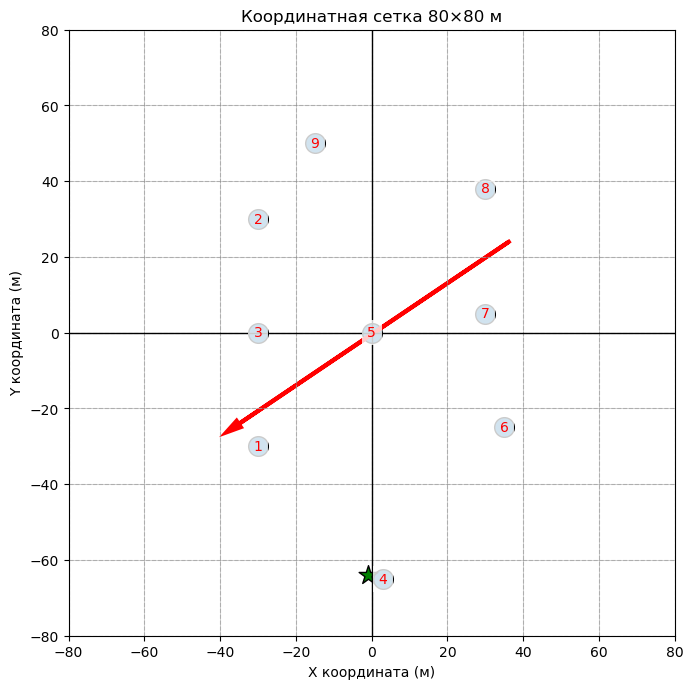

In [51]:
idx = 2

_, trigger_order = get_cluster_trigger_order(data['time'][idx])

real_x = data.iloc[idx].tolist()[1]
real_y = data.iloc[idx].tolist()[2]


fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlim(-80, 80)
ax.set_ylim(-80, 80)

for x in np.arange(-80, 81, 20):
    ax.axvline(x, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
for y in np.arange(-80, 81, 20):
    ax.axhline(y, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

ax.set_xlabel('X координата (м)')
ax.set_ylabel('Y координата (м)')
ax.set_title('Координатная сетка 80×80 м')

ax.set_xticks(np.arange(-80, 81, 20))
ax.set_yticks(np.arange(-80, 81, 20))

ax.set_aspect('equal')

ax.scatter([x[0] for x in cluster_centers], [x[1] for x in cluster_centers], s=200, edgecolors='black')

# Добавляем подписи с порядком срабатывания
for i, (x, y) in enumerate(cluster_centers):
    # Проверяем, что индекс есть в trigger_order
    if i in trigger_order:
        order = trigger_order.index(i) + 1  # Порядковый номер (начиная с 1)
        ax.text(x-0.01, y-0.01, str(order), 
                ha='center', va='center',
                fontsize=10, color='red',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))


angle_deg = 214
angle_rad = np.deg2rad(angle_deg)
length = 90  # Длина стрелки

end_x = length * np.cos(angle_rad)
end_y = length * np.sin(angle_rad)

plt.arrow(36.2, 24, end_x, end_y, 
          head_width=2.0, head_length=4.0, 
          fc='red', ec='red', linewidth=3,
          length_includes_head=True)


plt.scatter(real_x, real_y, c='green', s=200, marker='*', label='Настоящие коорды', edgecolors='black')


plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Попытка анализа полученных графиков не позволила выявить явный тренд, который позволяет улучшить точность определение Зенита и Азимута ШАЛ. Многие вхождения данных не позволяют понять направление движения Ливня. Следовательно, было принято решение сфокусироваться на оптимизации результатов других целевых переменных.  